# Data loading, Key factor definition

In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 74.5 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import gurobipy as gp
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import seaborn as sns

params = {
  'WLSACCESSID':'24738a6d-7010-4a14-b7f9-96e3f68dba1d',
  'WLSSECRET':'1f578b08-da1e-47e9-8f1c-edce1f91a2c4',
  'LICENSEID':2426147
}
env = gp.Env(params=params)

tl = 1800

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2426147
Academic license 2426147 - for non-commercial use only - registered to ke___@utexas.edu


In [ ]:
bins = 10
test = pd.read_csv('test_data.csv')
train = pd.read_csv('training_data.csv')
train.head(5)

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [ ]:
X, y = train.iloc[:,1:], train.iloc[:,0]

#EDA

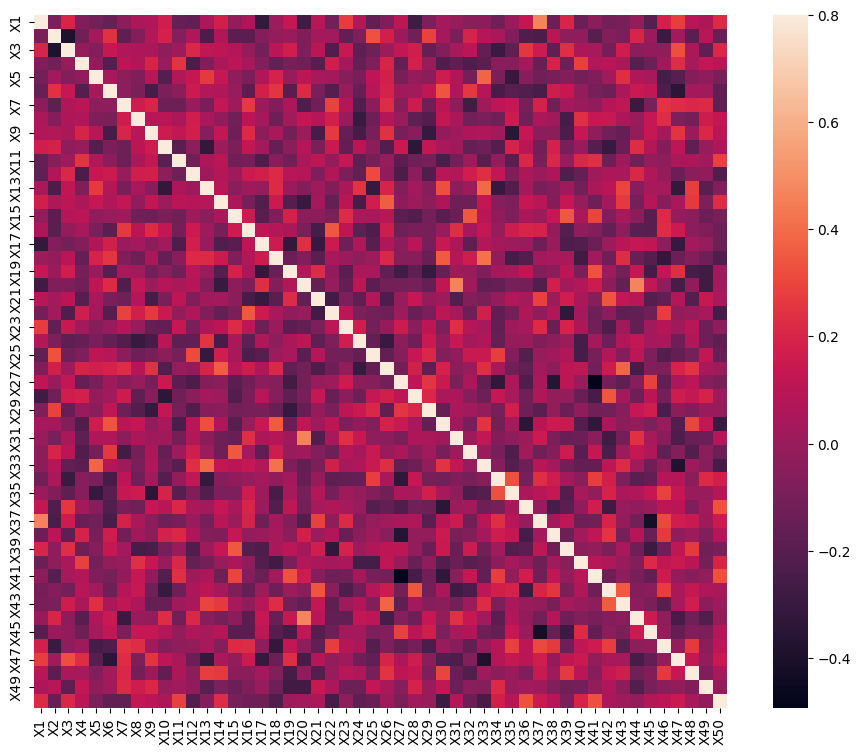

In [ ]:
# Correlation matrix
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

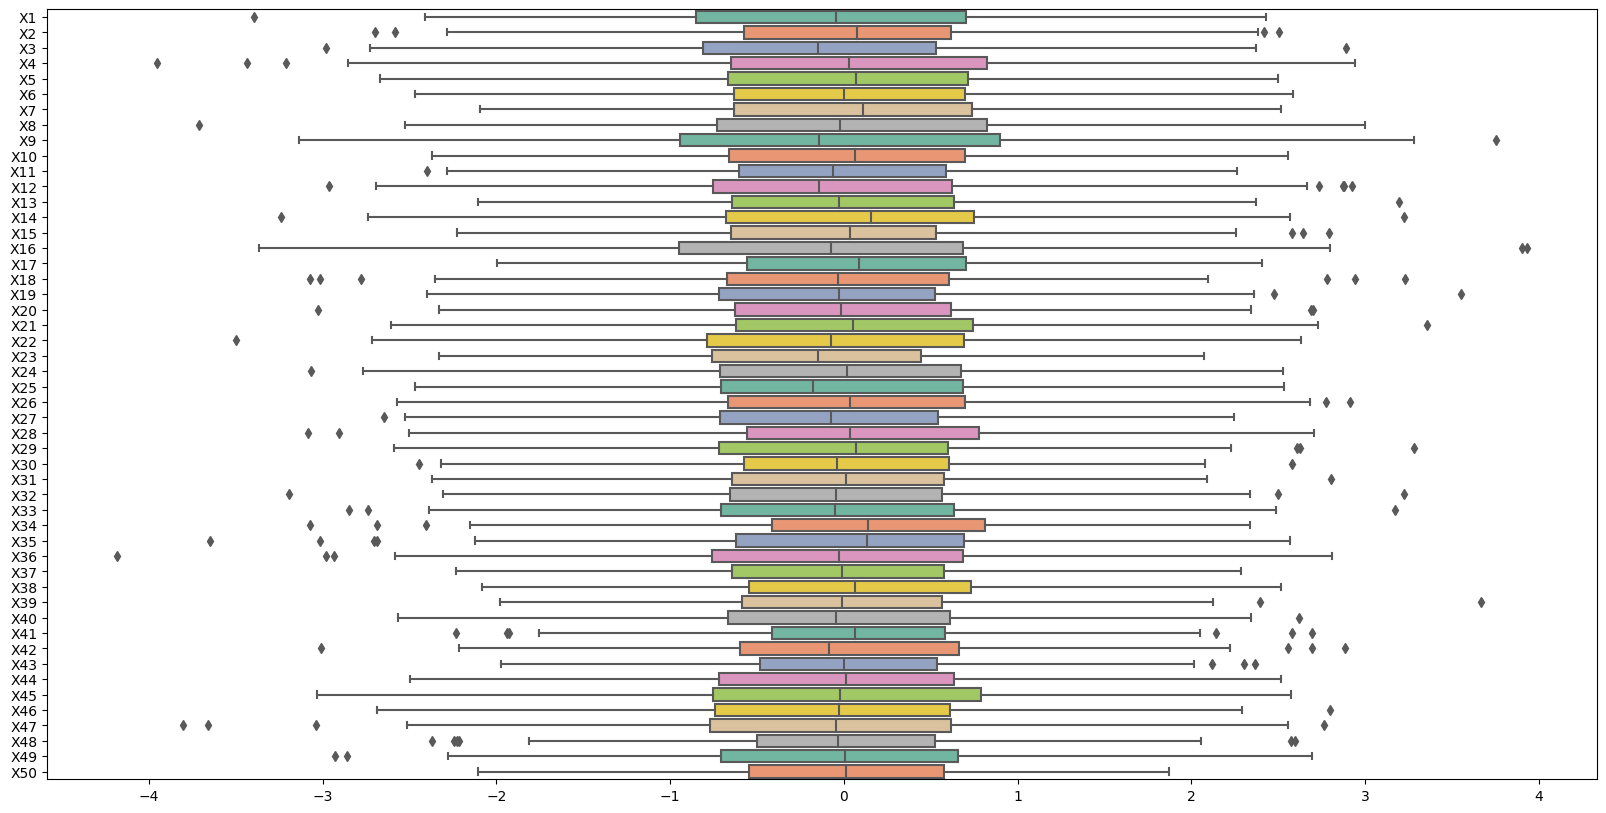

In [ ]:
#outliers
plt.figure(figsize=(20,10))
sns.boxplot(data=X, orient="h", palette="Set2")
plt.show()

In [ ]:
# Standardize the X
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_standardized = (X - X_mean) / X_std

# Standardize the target variable
y_mean = np.mean(y)
y_std = np.std(y)
y_standardized = (y - y_mean) / y_std

In [ ]:
n = len(X.index)
per_bin = n//bins
num_x = len(X.columns)

In [ ]:
shuf = np.random.choice(n, replace=False, size=n)

In [ ]:
shuf

array([ 41, 241,  30, 226,  29, 118, 163, 106,  17,  42, 220, 243,  81,
       143,  26, 109, 222,  74, 229,  22, 117,  53,  77,  43, 153, 192,
       215,   0, 112, 249, 204, 150, 239, 232,  58, 223, 138, 103,  68,
       183, 201, 142, 101, 240,  57,  31,  55, 134,  60,  89, 224, 130,
       214,  95, 196,  21, 110, 209, 124, 221, 212, 141, 164,  59, 217,
        84,  97,  47, 102,  18,  82,  35,  13, 165, 121, 113,  61,  75,
         2,  73, 206, 151, 115, 205, 157, 203,  88,  76,  80, 159, 108,
        94, 167, 236, 129, 162, 202, 146, 193, 148, 199,  27,  93, 140,
        36, 235, 171,  16,  44,  62,  11, 120, 179, 230, 186, 195,   7,
        71, 145, 184,   5,  50, 172, 218, 152, 211, 161, 119, 135, 216,
       122, 111, 246,  46,  56,  39, 210,  28,  87, 168, 245, 174, 244,
       154, 198, 173, 191,  65, 170, 139, 233, 116, 156,  24, 100,  67,
       227, 169,  86, 194,  92, 247,  98, 188, 231,   1, 189,  99,   3,
       213, 242,  14, 208, 149,   8,  10,  32, 132, 190, 238,  6

# Regular selection

## Cross-validate to find best k

In [ ]:
# define the method to detect if any beta equals M or -M, for accuracy, we set this equal as "very close to"
def good_M(M, arr):
  for b in arr:
    if abs(M-b)<=0.00000000000001 or abs(M+b)<=0.00000000000001:
      return False
  return True

In [ ]:
ks = [i for i in range(5,55,5)]
result = pd.DataFrame(columns=['k', 'loss'])
# set M at 0.01 in the beginning, and let it update itself
M = 0.01
losses = []
for k in tqdm(ks):
  total_loss = 0
  for bin in trange(bins):
    # splitting into validation and new training sets
    val = shuf[per_bin*bin:per_bin*(bin+1)]
    trn = list(set(shuf)-set(val))
    # splitting Xs and ys from the table
    X_trn, y_trn = X_standardized.iloc[trn], y_standardized.iloc[trn]
    X_val, y_val = X_standardized.iloc[val], y_standardized.iloc[val]
    lr = gp.Model(env=env)
    # there should be as much betas as number of X, and 1 more (the last one for code simplicity) that represents beta0
    beta = lr.addMVar(num_x, lb=-np.inf)
    z = lr.addMVar(num_x, vtype='B')
    big_M_up = lr.addConstrs(beta[i]<=z[i]*M for i in range(num_x))
    big_M_down = lr.addConstrs(beta[i]>=-z[i]*M for i in range(num_x))
    total_v = lr.addConstr(sum(z)<=k)
    target = gp.quicksum((gp.quicksum(beta[i]*X_trn.iloc[j,i] for i in range(num_x))-y_trn.iloc[j])
                        *(gp.quicksum(beta[i]*X_trn.iloc[j,i] for i in range(num_x))-y_trn.iloc[j]) for j in range(len(X_trn)))
    lr.setObjective(target, sense=gp.GRB.MINIMIZE)
    lr.Params.OutputFlag = 0
    lr.Params.TimeLimit = tl
    lr.optimize()
    test_M = good_M(M, beta.x)
    while not test_M:
      M *= 2
      lr = gp.Model(env=env)
      # there should be as much betas as number of X, and 1 more (the last one for code simplicity) that represents beta0
      beta = lr.addMVar(num_x, lb=-np.inf)
      z = lr.addMVar(num_x, vtype='B')
      big_M_up = lr.addConstrs(beta[i]<=z[i]*M for i in range(num_x))
      big_M_down = lr.addConstrs(beta[i]>=-z[i]*M for i in range(num_x))
      total_v = lr.addConstr(sum(z)<=k)
      target = gp.quicksum((gp.quicksum(beta[i]*X_trn.iloc[j,i] for i in range(num_x))-y_trn.iloc[j])*(gp.quicksum(beta[i]*X_trn.iloc[j,i] for i in range(num_x))-y_trn.iloc[j]) for j in range(len(X_trn)))
      lr.setObjective(target, sense=gp.GRB.MINIMIZE)
      lr.Params.OutputFlag = 0
      lr.Params.TimeLimit = tl
      lr.optimize()
      test_M = good_M(M, beta.x)
    for j in range(len(X_val)):
      cv_error = (np.dot(beta.x, X_val.iloc[j])-y_val.iloc[j])
      total_loss += cv_error * cv_error
  losses.append(total_loss)
  result.loc[len(result.index)] = [k, total_loss]
  print(f'The loss at k={k} is {total_loss}')
print(f'The smallest biggest value of M is {M}')
result.to_csv('final_result.csv')
files.download('final_result.csv')

 10%|█         | 1/10 [04:53<44:03, 293.73s/it]

The loss at k=5 is 1396.3495369470807



 20%|██        | 2/10 [07:57<30:34, 229.27s/it]

The loss at k=10 is 1212.9694708828217



 30%|███       | 3/10 [22:15<1:00:14, 516.29s/it]

The loss at k=15 is 1330.7582456071345



 40%|████      | 4/10 [1:21:38<2:51:53, 1718.99s/it]

The loss at k=20 is 1421.2057209339143



 50%|█████     | 5/10 [1:58:28<2:37:59, 1895.97s/it]

The loss at k=25 is 1418.0796096340966



 60%|██████    | 6/10 [2:11:04<1:40:33, 1508.45s/it]

The loss at k=30 is 1426.3529430152228



 60%|██████    | 6/10 [02:24<01:51, 27.96s/it]

In [ ]:
result = pd.read_csv('final_result.csv', index_col=0)

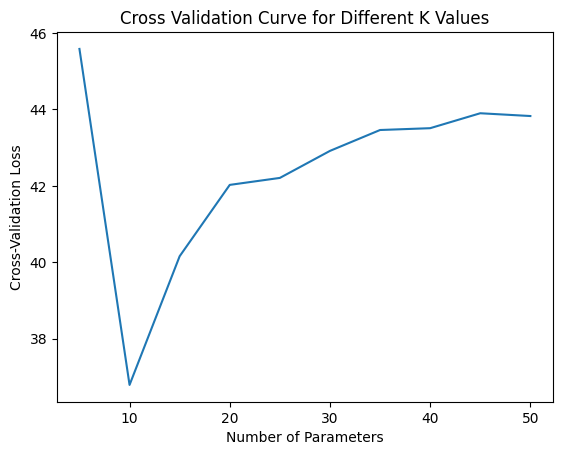

In [ ]:
plt.plot(result['k'], result['loss'])
plt.xlabel('Number of Parameters')
plt.ylabel('Cross-Validation Loss')
plt.title('Cross Validation Curve for Different K Values')
plt.show()

In [ ]:
print(f'The optimal value of M found is: {M}')

The optimal value of M found is: 3


## Fitting the best k model to the entire dataset, and check with test data

In [ ]:
record = result

In [ ]:
record.set_index('k', inplace=True)

In [ ]:
opt_k = record.idxmin().values[0]
X_test, y_test = test.iloc[:,1:], test.iloc[:,0]
lr = gp.Model(env=env)
beta = lr.addMVar(num_x+1, lb=-np.inf)
z = lr.addMVar(num_x, vtype='B')
big_M_up = lr.addConstrs(beta[i]<=z[i]*M for i in range(num_x))
big_M_down = lr.addConstrs(beta[i]>=-z[i]*M for i in range(num_x))
total_v = lr.addConstr(sum(z)<=opt_k)
target = gp.quicksum((beta[num_x]+gp.quicksum(beta[i]*X.iloc[j,i] for i in range(num_x))-y.iloc[j])
                    *(beta[num_x]+gp.quicksum(beta[i]*X.iloc[j,i] for i in range(num_x))-y.iloc[j]) for j in range(n))
lr.setObjective(target, sense=gp.GRB.MINIMIZE)
lr.Params.OutputFlag = 0
lr.Params.TimeLimit = tl
lr.optimize()

In [ ]:
beta.x

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -2.30820726,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.51832612,
       -0.20416201,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.55914318,  0.86697336,  0.        ,
       -1.31191942,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.4081653 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.78147489,
        0.        ,  0.88738292, -0.28229213,  0.        ,  0.        ,
        0.97252408])

In [ ]:
b0 = y_mean - sum(beta.x[0:num_x] * X_mean / X_std)

In [ ]:
real_beta = beta.x[0:num_x] * y_std / X_std

In [ ]:
print(f'The optimal linear function is: y=', end='')
for i, b in enumerate(real_beta):
  if b!=0:
    print(f'({b}*X{i+1})', end='+')
print(b0)

The optimal linear function is: y=(-8.008034490080856*X9)+(-2.433190196888334*X15)+(-0.7072455836386933*X16)+(-8.167963131761068*X23)+(3.6648773878066345*X24)+(-5.920126946075696*X26)+(1.8713608214876223*X34)+(7.4577203393400735*X45)+(3.7753662234406145*X47)+(-1.4758703445563228*X48)+0.9628382728938847


In [ ]:
y_pred_sel = np.dot(X_test, beta.x[0:num_x])+beta.x[num_x]
selection_loss = sum((y_test-y_pred_sel)**2)

In [ ]:
y_act = y_test.copy()

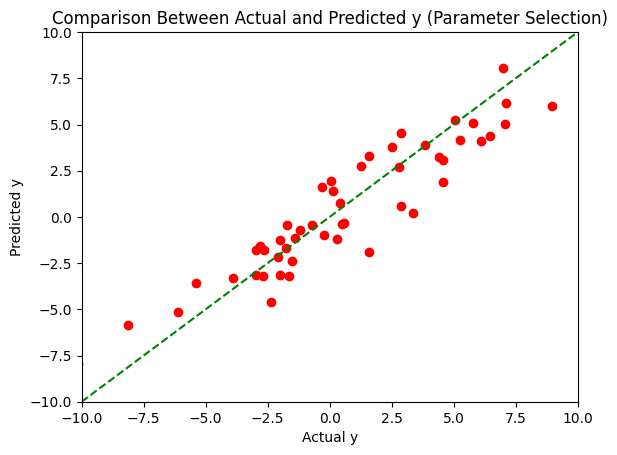

In [ ]:
plt.scatter(y_act, y_pred_sel, color='r')
plt.plot([-10,10], [-10,10], linestyle='--', color='g')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Comparison Between Actual and Predicted y (Parameter Selection)')
plt.show()

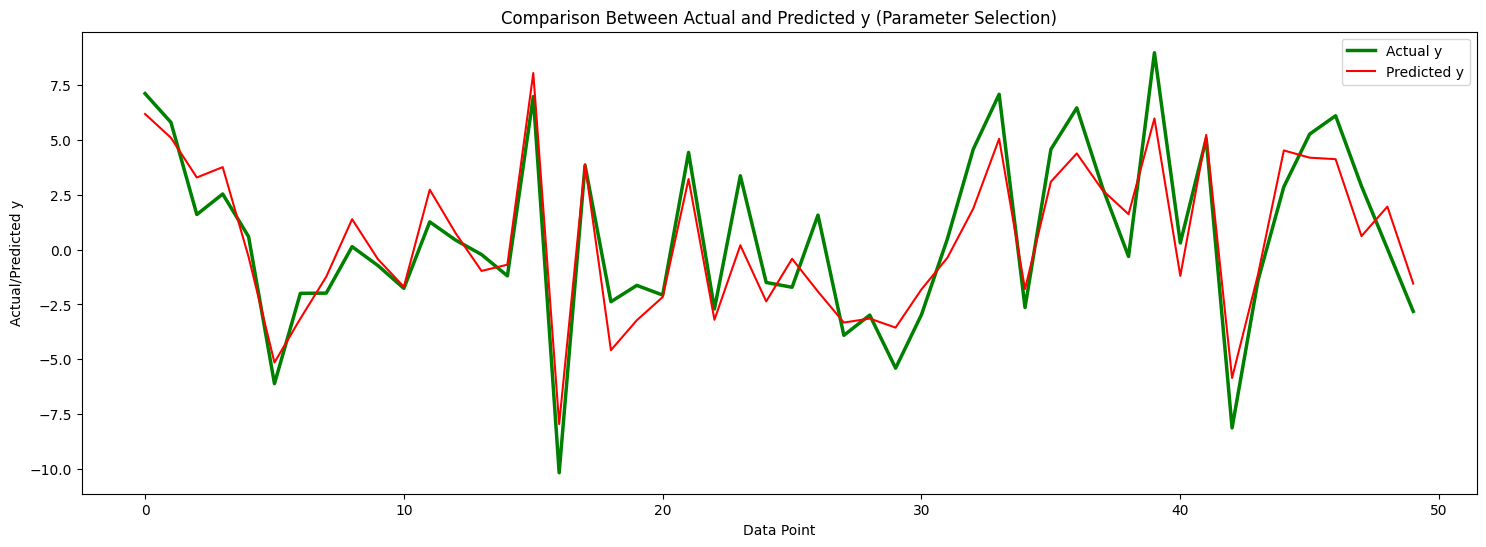

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(y_test.index, y_act, color='g', label='Actual y', linewidth=2.5)
plt.plot(y_test.index, y_pred_sel, color='r', label='Predicted y')
plt.xlabel('Data Point')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y (Parameter Selection)')
plt.legend()
plt.show()

In [ ]:
print(f'Total SSE loss from selection is {selection_loss}')

Total SSE loss from selection is 116.82719822762624


# Lasso selection

## Cross-validate to find lambda

In [ ]:
from sklearn.linear_model import LassoCV, Lasso

In [ ]:
X_test, y_test = test.iloc[:,1:], test.iloc[:,0]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

alphas = np.logspace(-3, 3, 20000)

lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=1000)
lasso_cv.fit(X_train_scaled, y)

cv_errors = np.mean(lasso_cv.mse_path_, axis=1)

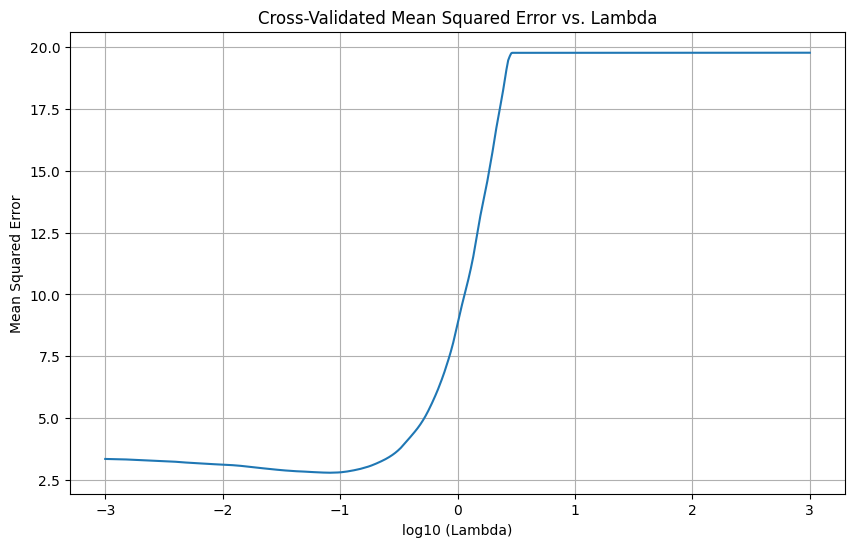

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lasso_cv.alphas_), cv_errors, linestyle='-')
plt.title('Cross-Validated Mean Squared Error vs. Lambda')
plt.xlabel('log10 (Lambda)')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

In [ ]:
best_alpha = lasso_cv.alpha_
print(f'The best lambda values is {best_alpha}')

The best lambda values is 0.08285064900697924


100%|██████████| 20000/20000 [01:54<00:00, 174.12it/s]


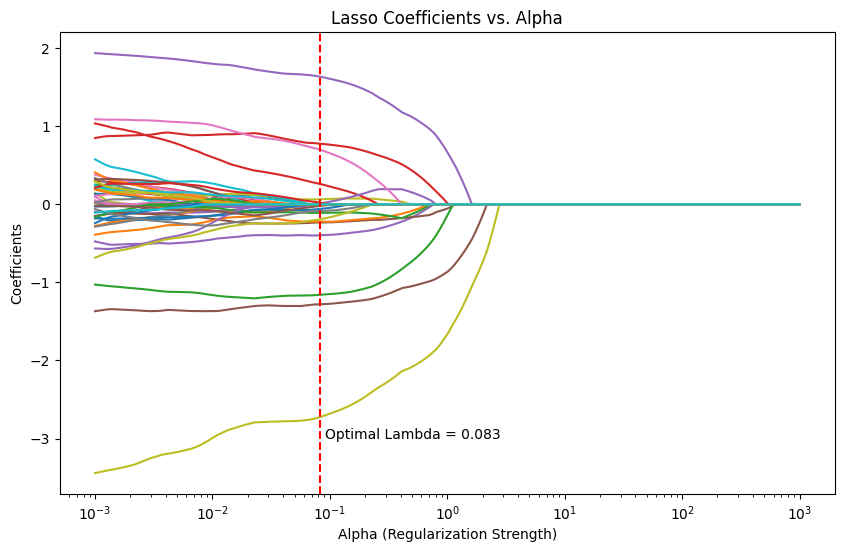

In [ ]:
coefs = []

for alpha in tqdm(alphas):
  lasso = Lasso(alpha=alpha, max_iter=10000)
  lasso.fit(X_standardized, y)
  coefs.append(lasso.coef_)

# Plotting the coefficients against alpha values
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs)
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Alpha = {best_alpha}')
plt.text(best_alpha * 1.1, -3, f'Optimal Lambda = {best_alpha:.3f}', color='black')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients vs. Alpha')
# plt.legend([f'Coefficient {i+1}' for i in range(X.shape[1])])
plt.show()

## Fitting the best lambda model to the test data and check for loss

In [ ]:
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X, y)
y_pred_lasso = lasso_model.predict(X_test)

In [ ]:
lasso_loss = np.sum((y_test - y_pred_lasso)**2)

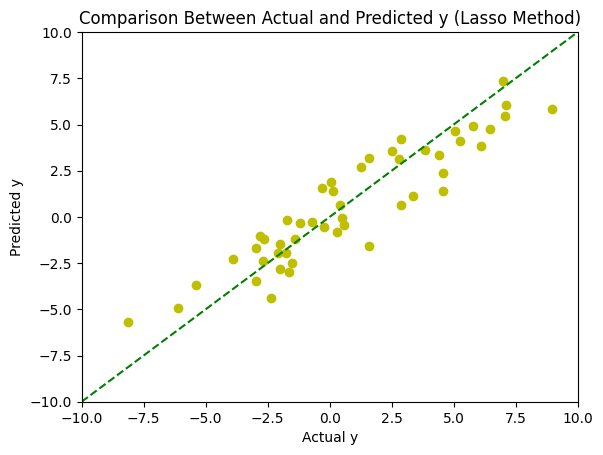

In [ ]:
plt.scatter(y_test, y_pred_lasso, color='y')
plt.plot([-10,10], [-10,10], linestyle='--', color='g')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Comparison Between Actual and Predicted y (Lasso Method)')
plt.show()

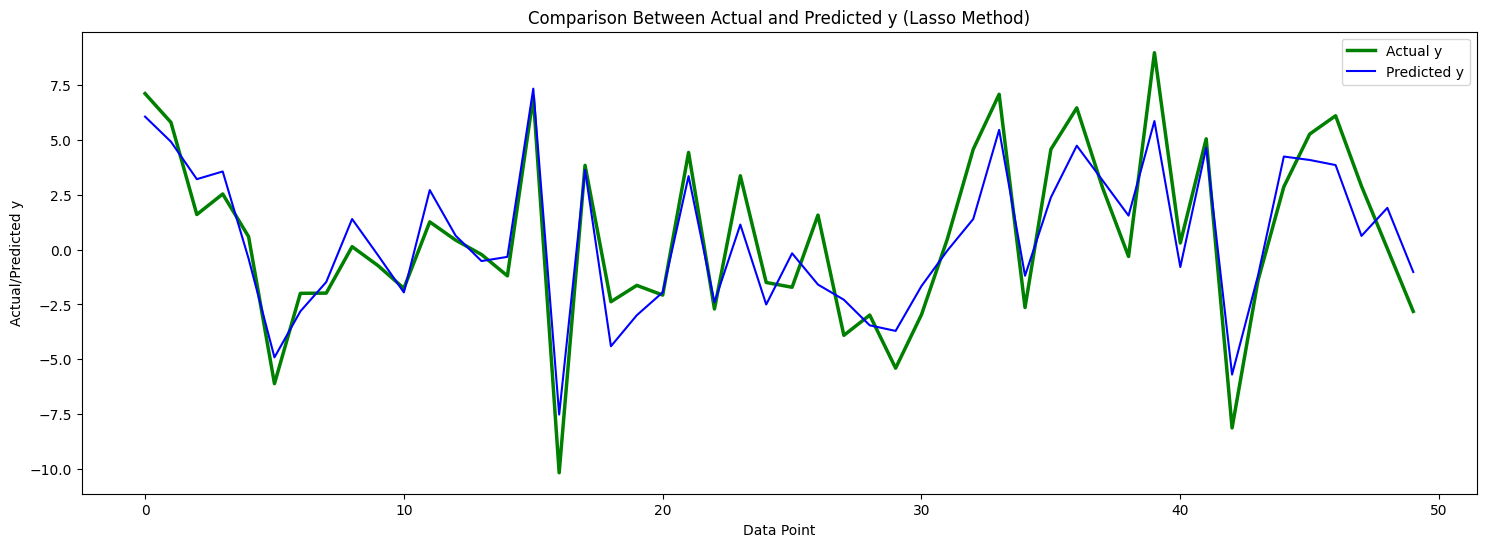

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(y_test.index, y_test, color='g', label='Actual y', linewidth=2.5)
plt.plot(y_test.index, y_pred_lasso, color='b', label='Predicted y')
plt.xlabel('Data Point')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y (Lasso Method)')
plt.legend()
plt.show()

In [ ]:
print(f'Total SSE loss from Lasso is {lasso_loss}')

Total SSE loss from Lasso is 117.5905209374478


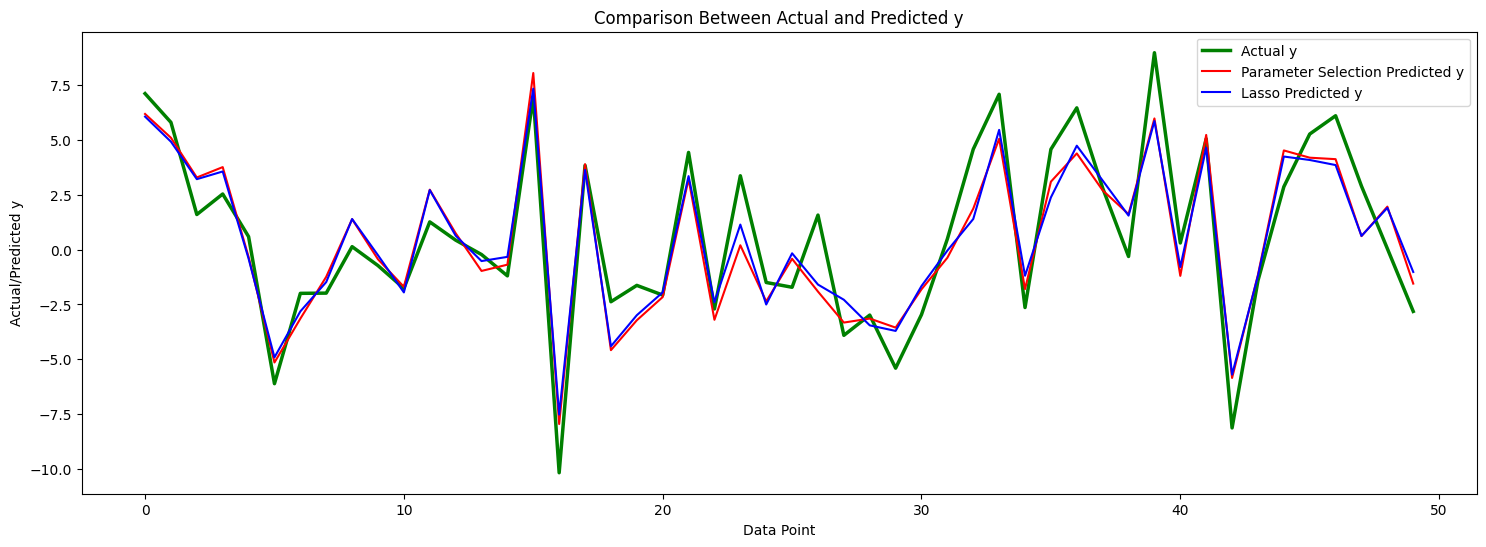

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(y_test.index, y_test, color='g', label='Actual y', linewidth=2.5)
plt.plot(y_test.index, y_pred_sel, color='r', label='Parameter Selection Predicted y')
plt.plot(y_test.index, y_pred_lasso, color='b', label='Lasso Predicted y')
plt.xlabel('Data Point')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y')
plt.legend()
plt.show()

In [ ]:
print(f'The total loss from Parameter Selection is {selection_loss}')
print(f'The total loss from Lasso is {lasso_loss}')

The total loss from Parameter Selection is 116.82719822762624
The total loss from Lasso is 117.5905209374478


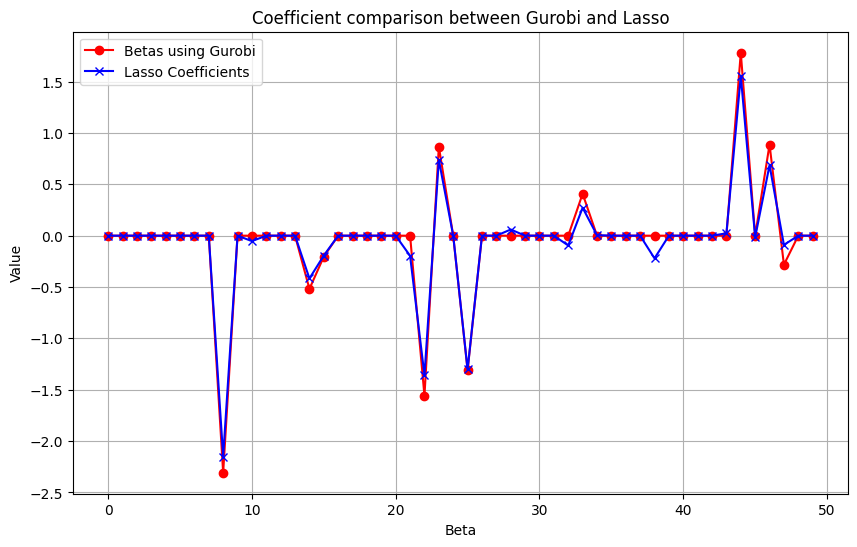

In [ ]:
lasso_coefficients = lasso_model.coef_
beta_values = beta.x
plt.figure(figsize=(10, 6))
plt.plot(range(len(lasso_coefficients)), beta_values[:50].tolist(), color='red', marker='o', linestyle='-', label='Betas using Gurobi')
plt.plot(range(len(lasso_coefficients)), lasso_coefficients, color='blue', marker='x', linestyle='-', label='Lasso Coefficients')

# Adding labels and title
plt.title('Coefficient comparison between Gurobi and Lasso')
plt.xlabel('Beta')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
lasso_coefficients

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -2.15064387,  0.        ,
       -0.05292745,  0.        , -0.        , -0.        , -0.41685917,
       -0.19314757,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.19585237, -1.35940551,  0.73733139, -0.        ,
       -1.3028989 , -0.        ,  0.        ,  0.06005312,  0.        ,
       -0.        ,  0.        , -0.09563065,  0.27213897,  0.0048954 ,
        0.        ,  0.        ,  0.        , -0.22085194,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.02298867,  1.5559679 ,
       -0.01531347,  0.68620875, -0.08938469,  0.        ,  0.        ])